In [1]:
import os
from keras import applications
#from keras.applications.vgg16 import VGG16
#from keras.applications.vgg19 import VGG19
#from keras.applications.resnet50 import ResNet50
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input
import numpy as np
import math
import pandas as pd
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
import scikitplot as skplt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

pd.options.mode.chained_assignment = None

%matplotlib inline

k.set_image_dim_ordering('tf')

Using TensorFlow backend.


In [19]:
#inputs
path = '/home/paperspace/Documents/SETI/ML/data/my_images/'

train_dir = path + 'train/'
validation_dir = path + 'valid/'
test_dir = path + 'test/'

#outputs
cnn_outputs = path + 'cnn_outputs/'

img_dim  = 197

In [21]:
def make_folder(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

In [22]:
#Make the output folders,
make_folder(cnn_outputs)

In [4]:
#Generators
train_datagen = ImageDataGenerator(
  #rescale = 1/255,
  rotation_range = 180,
  #width_shift_range = 0.1,
  #height_shift_range = 0.1,
  #shear_range = 10,
  #zoom_range = 5,
  horizontal_flip = True,
  vertical_flip = True,
  fill_mode = "reflect")

# Note that the validation data shouldn't be augmented!
validation_datagen = ImageDataGenerator(#rescale = 1/255
                                        )  
test_datagen = ImageDataGenerator(#rescale = 1/255
                                  )  

In [5]:
training_batch_size = 64
validation_batch_size = 64

train_generator = train_datagen.flow_from_directory(
  train_dir,                                                  
  classes = ('noise', 'squiggle', 'narrowband', 'narrowbanddrd', 'squarepulsednarrowband', 
            'squigglesquarepulsednarrowband', 'brightpixel'),
  target_size = (img_dim, img_dim),            
  batch_size = training_batch_size,
  class_mode = "categorical",
  shuffle = True,
  seed = 123)

Found 5600 images belonging to 7 classes.


In [6]:
validation_generator = validation_datagen.flow_from_directory(
  validation_dir,
  classes = ('noise', 'squiggle', 'narrowband', 'narrowbanddrd', 'squarepulsednarrowband', 
            'squigglesquarepulsednarrowband', 'brightpixel'),
  target_size = (img_dim, img_dim),
  batch_size = validation_batch_size,
  class_mode = "categorical",
  shuffle = True,
  seed = 123)

Found 700 images belonging to 7 classes.


In [28]:
test_size = 707
test_batch_size = 1

test_generator = test_datagen.flow_from_directory(
  test_dir,
  classes = ('noise', 'squiggle', 'narrowband', 'narrowbanddrd', 'squarepulsednarrowband', 
            'squigglesquarepulsednarrowband', 'brightpixel'),
  target_size = (img_dim, img_dim),
  batch_size = test_batch_size,
  class_mode = "categorical",
  shuffle = False)

Found 707 images belonging to 7 classes.


## Transfer Learning

In [8]:
base = InceptionResNetV2(
  weights = "imagenet",
  include_top = False,
  input_shape = (img_dim, img_dim, 3)
)

In [9]:
#InceptionV3
x = base.output
x = Flatten(input_shape=base.output_shape[1:])(x)
#x = Dense(img_dim/2, activation="relu")(x)
#x = Dropout(0.2)(x)
x = Dense(img_dim, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(7, activation="softmax")(x)

In [10]:
#Inception
model = Model(inputs=base.input, outputs=x)

In [11]:
#use transfer learning for re-training the last layers
for layer in model.layers:
   layer.trainable = True

In [12]:
#https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning

def step_decay(epoch):
    initial_lrate = 1e-4
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, 
            math.floor((1+epoch)/epochs_drop))
    return(lrate)

lrate = LearningRateScheduler(step_decay)

In [13]:
# Compile the model
model.compile(loss = "binary_crossentropy", optimizer = optimizers.rmsprop(lr=1e-5), metrics=["accuracy"])

In [14]:
training_step_size = 64
validation_step_size = 32

In [16]:
#Train

history = model.fit_generator(
  train_generator,
  steps_per_epoch = training_step_size,
  epochs = 10,
  validation_data = validation_generator,
  validation_steps = validation_step_size,
  #callbacks = [lrate]
)

Epoch 1/10
64/64 [==============================] - 72s 1s/step - loss: 0.2515 - acc: 0.8883 - val_loss: 0.2941 - val_acc: 0.8822
Epoch 2/10
64/64 [==============================] - 72s 1s/step - loss: 0.2472 - acc: 0.8891 - val_loss: 0.2854 - val_acc: 0.8882
Epoch 3/10
64/64 [==============================] - 72s 1s/step - loss: 0.2363 - acc: 0.8936 - val_loss: 0.2884 - val_acc: 0.8846
Epoch 4/10
64/64 [==============================] - 73s 1s/step - loss: 0.2341 - acc: 0.8974 - val_loss: 0.2746 - val_acc: 0.8891
Epoch 5/10
64/64 [==============================] - 72s 1s/step - loss: 0.2309 - acc: 0.8947 - val_loss: 0.2750 - val_acc: 0.8881
Epoch 6/10
64/64 [==============================] - 72s 1s/step - loss: 0.2204 - acc: 0.8981 - val_loss: 0.2665 - val_acc: 0.8930
Epoch 7/10
64/64 [==============================] - 71s 1s/step - loss: 0.2179 - acc: 0.9015 - val_loss: 0.2693 - val_acc: 0.8918
Epoch 8/10
64/64 [==============================] - 71s 1s/step - loss: 0.2147 - acc: 0.90

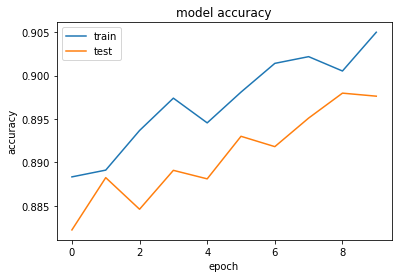

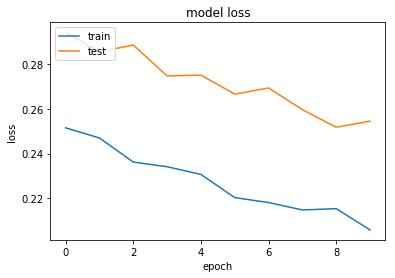

In [17]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [23]:
model.save(cnn_outputs + 'seti_inc3_ft_20181210_v1.h5')
model.save_weights(cnn_outputs + 'seti_weights_inc3_ft_20181210_v1.h5')

## Predict on the test set

In [1]:
predictions = model.predict_generator(test_generator, steps = test_size, verbose = 1)

NameError: name 'model' is not defined

In [30]:
df = pd.DataFrame(predictions)
df['filename'] = test_generator.filenames

In [32]:
df['truth'] = ''
df['truth'] = df['filename'].str.split('/', 1, expand = True)
df['prediction_index'] = df[[0,1,2,3,4,5,6]].idxmax(axis=1)

df['prediction'] = ''
df['prediction'][df['prediction_index'] == 0] = 'noise'
df['prediction'][df['prediction_index'] == 1] = 'squiggle'
df['prediction'][df['prediction_index'] == 2] = 'narrowband'
df['prediction'][df['prediction_index'] == 3] = 'narrowbanddrd'
df['prediction'][df['prediction_index'] == 4] = 'squarepulsednarrowband'
df['prediction'][df['prediction_index'] == 5] = 'squigglesquarepulsednarrowband'
df['prediction'][df['prediction_index'] == 6] = 'brightpixel'

cm = confusion_matrix(df['truth'], df['prediction'])

accuracy_score(df['truth'], df['prediction'])

0.5601131541725601

In [33]:
cm_df = pd.DataFrame(cm)
cm_df.columns = ['noise', 'squiggle', 'narrowband', 'narrowbanddrd', 'squarepulsednarrowband', 
            'squigglesquarepulsednarrowband', 'brightpixel']

cm_df['signal'] = ('noise', 'squiggle', 'narrowband', 'narrowbanddrd', 'squarepulsednarrowband', 
            'squigglesquarepulsednarrowband', 'brightpixel')

cm_df

,noise,squiggle,narrowband,narrowbanddrd,squarepulsednarrowband,squigglesquarepulsednarrowband,brightpixel,signal
0,52,0,0,25,5,0,19,noise
1,1,44,19,11,21,2,3,squiggle
2,0,11,52,8,28,0,2,narrowband
3,2,0,0,53,16,0,30,narrowbanddrd
4,0,2,5,17,60,4,13,squarepulsednarrowband
5,0,0,0,2,0,99,0,squigglesquarepulsednarrowband
6,1,2,0,26,26,10,36,brightpixel
